# 🕵🏻 Camouflage Detection Project - Deep Learning

## Group - 10

1. Manthan Patel - 1008247933
2. Sudev Thazhakode - 1007992576
3. Trupal Patel - 1008326152

# 📰 Project Status
---

## 🗃️ Data

Currently we have a total of 5 datasets:
1. COD10K dataset 
2. CAMO 
3. NC4K 
4. military personnel data 
5. MoCA 

* We have collected most of the data, from which we can use one dataset as test data and the other datasets for training 
  
* Now we are looking for more camouflaged people's data for testing and validation 

---

## 🤖 Model 

* In the SINet paper, we tried to run the model on the COD10K dataset.

* In our project so far, we have tried to run COD10K, MoCA video data and military data on our local computers. And we have obtained good results.
  
* In this file, we show the results of COD10K and MoCA as an example.
  
---

## 👩🏽‍🔬 Scope of Improvement

* As future work, we will tune the SINet model to these new datasets and present our comparison study. > As an improvement, we plan to change the backbone structure, which is currently ResNet, but we want to use a different architecture for transfer learning. > In parallel, we will try to create a new base type of model and implement camouflage detection task with this new model and compare it with the SINet model.
  
* As mentioned earlier, these two tasks can be done in parallel, so we can easily complete the project work within the available time frame.

---

## 🎯 Project Deliverables

* As a final deliverable, we aim to present a working model that can perform camouflage detection of animals and hopefully military personnel.

* Currently, SINet os only performs this task on the COD10k dataset, which does not contain much data on humans, so we will try to use our model to learn these as well.


Converting to HTML

In [ ]:
%%shell
jupyter nbconvert --to html DLProject.ipynb

[NbConvertApp] Converting notebook DLProject.ipynb to html
[NbConvertApp] Writing 876883 bytes to DLProject.html


## 📥 Import Files


In [ ]:
#Train File
import torch
import argparse

torch.cuda.empty_cache()

#Search Attention Module
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.parameter import Parameter
import numpy as np
import scipy.stats as st

#SINet
import torchvision.models as models

#Data Loader
import os
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2

#Trainer File
from torch.autograd import Variable
from datetime import datetime
import os

#ResNet
import math

#Video Loader
import os
from PIL import Image, ImageEnhance
import torch.utils.data as data
import torchvision.transforms as transforms
import random

from glob import glob
import os.path as osp


#Test File
from scipy import misc  # NOTES: pip install scipy == 1.2.2 (prerequisite!)
import imageio

import matplotlib.pyplot as plt



Unzipping Data Files

In [ ]:
!unzip Military_data.zip

In [ ]:
!unzip TestDataset.zip

In [ ]:
!unzip TrainDataset.zip

In [ ]:
!unzip MoCA-Mask.zip

# 🧱 Backbone Structure Files


##ResNet Model

In [ ]:
##ResNet File

def conv3x3(in_planes, out_planes, stride=1):
    """
    3x3 convolution with padding
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_2Branch(nn.Module):
    # ResNet50 with two branches (modified from torchvision.models.resnet (pytorch==0.4.1))
    def __init__(self):
        # self.inplanes = 128
        self.inplanes = 64
        super(ResNet_2Branch, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3_1 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_1 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.inplanes = 512
        self.layer3_2 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_2 = self._make_layer(Bottleneck, 512, 3, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x1 = self.layer3_1(x)
        x1 = self.layer4_1(x1)

        x2 = self.layer3_2(x)
        x2 = self.layer4_2(x2)

        return x1, x2


## 🧰 Utility Functions

Trainer Function

In [ ]:
#Trainer File
def eval_mae(y_pred, y):
    """
    evaluate MAE (for test or validation phase)
    :param y_pred:
    :param y:
    :return: Mean Absolute Error
    """
    return torch.abs(y_pred - y).mean()


def numpy2tensor(numpy):
    """
    convert numpy_array in cpu to tensor in gpu
    :param numpy:
    :return: torch.from_numpy(numpy).cuda()
    """
    return torch.from_numpy(numpy).cuda()


def clip_gradient(optimizer, grad_clip):
    """
    recalibrate the misdirection in the training
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay


def trainer(train_loader, model, optimizer, epoch, opt, loss_func, total_step):
    """
    Training iteration
    :param train_loader:
    :param model:
    :param optimizer:
    :param epoch:
    :param opt:
    :param loss_func:
    :param total_step:
    :return:
    """
    total_loss = 0
    model.train()
    for step, data_pack in enumerate(train_loader):
        optimizer.zero_grad()
        images, gts = data_pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()

        cam_sm, cam_im = model(images)
        loss_sm = loss_func(cam_sm, gts)
        loss_im = loss_func(cam_im, gts)
        loss_total = loss_sm + loss_im

        #with amp.scale_loss(loss_total, optimizer) as scale_loss:
        #    scale_loss.backward()
        loss_total.backward()
        total_loss += loss_total.data.item()


        # clip_gradient(optimizer, opt.clip)
        optimizer.step()

        if step % 10 == 0 or step == total_step:
            print('[{}] => [Epoch Num: {:03d}/{:03d}] => [Global Step: {:04d}/{:04d}] => [Loss_s: {:.4f} Loss_i: {:0.4f}]'.
                  format(datetime.now(), epoch, opt.epoch, step, total_step, loss_sm.data, loss_im.data))

    
    save_path = opt.save_model
    os.makedirs(save_path, exist_ok=True)

    if (epoch+1) % opt.save_epoch == 0:
        torch.save(model.state_dict(), save_path + 'SINet_batch%d_%d.pth' % (opt.batchsize , (epoch+1)) )

    return total_loss, step


DataLoader 

In [ ]:
#Dataloader file


class CamObjDataset(data.Dataset):
    def __init__(self, image_root, gt_root, trainsize):
        self.trainsize = trainsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg')
                    or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        self.size = len(self.images)
        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        image = self.img_transform(image)
        gt = self.gt_transform(gt)
        return image, gt

    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size


class test_dataset:
    """load test dataset (batchsize=1)"""
    def __init__(self, image_root, gt_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        image = self.transform(image).unsqueeze(0)
        gt = self.binary_loader(self.gts[self.index])
        name = self.images[self.index].split('/')[-1]
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'
        self.index += 1
        return image, gt, name

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')


class test_loader_faster(data.Dataset):
    def __init__(self, image_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg')]
        self.images = sorted(self.images)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.size = len(self.images)

    def __getitem__(self, index):
        images = self.rgb_loader(self.images[index])
        images = self.transform(images)

        img_name_list = self.images[index]

        return images, img_name_list

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def __len__(self):
        return self.size


def get_loader(image_root, gt_root, batchsize, trainsize, shuffle=True, num_workers=0, pin_memory=True):
    # `num_workers=0` for more stable training
    dataset = CamObjDataset(image_root, gt_root, trainsize)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)

    return data_loader

Video File Dataloader for MoCA Dataset

In [ ]:
#Video Data Loader file
#several data augumentation strategies

def cv_random_flip(imgs, label):
    # left right flip
    flip_flag = random.randint(0, 1)
    if flip_flag == 1:
        for i in range(len(imgs)):
            imgs[i] = imgs[i].transpose(Image.FLIP_LEFT_RIGHT)
        label = label.transpose(Image.FLIP_LEFT_RIGHT)
    return imgs, label


def randomCrop(imgs, label):
    border = 30
    image_width = imgs[0].size[0]
    image_height = imgs[0].size[1]
    crop_win_width = np.random.randint(image_width - border, image_width)
    crop_win_height = np.random.randint(image_height - border, image_height)
    random_region = (
        (image_width - crop_win_width) >> 1, (image_height - crop_win_height) >> 1, (image_width + crop_win_width) >> 1,
        (image_height + crop_win_height) >> 1)

    for i in range(len(imgs)):
        imgs[i] = imgs[i].crop(random_region)
    return imgs, label.crop(random_region)


def randomRotation(imgs, label):
    mode = Image.BICUBIC
    if random.random() > 0.8:
        random_angle = np.random.randint(-15, 15)
        for i in range(len(imgs)):
            imgs[i] = imgs[i].rotate(random_angle, mode)
        label = label.rotate(random_angle, mode)
    return imgs, label


def colorEnhance(imgs):
    for i in range(len(imgs)):
        bright_intensity = random.randint(5, 15) / 10.0
        imgs[i] = ImageEnhance.Brightness(imgs[i]).enhance(bright_intensity)
        contrast_intensity = random.randint(5, 15) / 10.0
        imgs[i] = ImageEnhance.Contrast(imgs[i]).enhance(contrast_intensity)
        color_intensity = random.randint(0, 20) / 10.0
        imgs[i] = ImageEnhance.Color(imgs[i]).enhance(color_intensity)
        sharp_intensity = random.randint(0, 30) / 10.0
        imgs[i] = ImageEnhance.Sharpness(imgs[i]).enhance(sharp_intensity)
    return imgs


def randomPeper(img):
    img = np.array(img)
    noiseNum = int(0.0015 * img.shape[0] * img.shape[1])

    for i in range(noiseNum):
        randX = random.randint(0, img.shape[0] - 1)
        randY = random.randint(0, img.shape[1] - 1)

        if random.randint(0, 1) == 0:
            img[randX, randY] = 0
        else:
            img[randX, randY] = 255
    return Image.fromarray(img)


class VideoDataset(data.Dataset):
    def __init__(self, data_root, trainsize):
        self.trainsize = trainsize
        #self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg')]
        #self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.jpg')
        #            or f.endswith('.png')]
        #self.images = sorted(self.images)
        #self.gts = sorted(self.gts)
        self.images = []
        self.gts = []

        for scene in os.listdir(osp.join(data_root)):
            image = sorted(glob(osp.join(data_root, scene, 'Imgs', '*.jpg')))
            gt_list = sorted(glob(osp.join(data_root, scene, 'GT', '*.png')))
            self.images += image
            self.gts += gt_list
        self.filter_files()
        self.size = len(self.images)
        self.img_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.trainsize, self.trainsize)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        image = self.img_transform(image)
        #image, gt = randomRotation(image, gt)
        gt = self.gt_transform(gt)
        #image = colorEnhance(image)
        #gt = randomPeper(gt)
        return image, gt

    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size


# dataloader for training
def get_vloader(data_root, batchsize, trainsize,
               shuffle=True, num_workers=12, pin_memory=True):
    dataset = VideoDataset(data_root, trainsize)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader

class test_dataset:
    """load test dataset (batchsize=1)"""
    def __init__(self, data_root, testsize):
        self.testsize = testsize

        self.images = []
        self.gts = []

        for scene in os.listdir(osp.join(data_root)):
            image = sorted(glob(osp.join(data_root, scene, 'Imgs', '*.jpg')))
            gt_list = sorted(glob(osp.join(data_root, scene, 'GT', '*.png')))
            self.images += image
            self.gts += gt_list
        #self.filter_files()
        self.size = len(self.images)
        
        
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        image = self.transform(image).unsqueeze(0)
        gt = self.binary_loader(self.gts[self.index])
        name = self.images[self.index].split('/')[-1]
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'
        self.index += 1
        return image, gt, name

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

    def __len__(self):
        return self.size


Masking Visualisation Functions

In [ ]:
# Visualisation Functions


# pred_root_path = '/content/gdrive/MyDrive/DLProject/Results/COD10K/bsize_32/COD10K/'
# true_root_path = '/content/TestDataset/COD10K/Image/'



def result_plot(mask_path, true_root_path):

    img_directory = os.listdir(true_root_path)[150:160]
    i = 0
    img_list = []
    # pred_list = []

    for k,img_gt in enumerate(img_directory):
        img_list.append(img_gt)
        print(img_list)

    for i in range(len(img_list)):
        plt.figure(figsize=(10,20))
        img_gt= Image.open(true_root_path+"/"+ img_list[i])
        plt.subplot(1,2,1)
        plt.imshow(img_gt)

        images = img_gt.convert('RGB')
        img_copy = np.copy(images)
        
        # img_pred = Image.open(pred_root_path+"/"+ img_list[i])
        mask = cv2.imread(os.path.join(mask_path, img_list[i].split(".")[0] + '.png'))
        # img_pred = img_pred.astype(np.uint8)
        _, masks = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        img_final = apply_mask(img_copy,masks)
        plt.subplot(1,2,2)
        plt.imshow(img_final)

def video_maker(image_folder,video_name):
    image_folder = image_folder
    video_name = video_name

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()




def mask_load_moca(data_root, mask_root, save_path):

    for scene in os.listdir(osp.join(data_root)):
        print("Scene name:", scene)
        image = sorted(glob(osp.join(data_root, scene, 'Imgs', '*.jpg')))
        file = sorted(os.listdir(osp.join(data_root, scene, 'Imgs')))
        mask = sorted(glob(osp.join(mask_root, scene, '*.png')))
        directory = scene
  
        # Parent Directory path
        parent_dir = '/content/gdrive/My Drive/DLProject/Results/MoCA/'
        # Path
        path = os.path.join(parent_dir, directory)     
        # Create the directory
        os.mkdir(path)

        for i in range(len(image)):
            images = rgb_loader(image[i])

            masks = cv2.imread(mask[i])
            _, masks = cv2.threshold(masks, 127, 255, cv2.THRESH_BINARY)

            img_copy = np.copy(images)
            new_image = apply_mask(img_copy, masks)
            new_name = str(scene) + '_' + str(file[i])
            imageio.imwrite(path + '/' + new_name, new_image)


def rgb_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def apply_mask(image, mask):
    """Apply the given mask to the image.
    """
    image = np.squeeze(image)
    color = np.array([0, 255, 0], dtype='uint8')
    masked_img = np.where(mask != 0, color, image)
    image = cv2.addWeighted(image, 0.4, masked_img, 0.5, 0)
    return image


## 🧠 Main Network 

Search Attention Module

In [ ]:
#SA Module files
def _get_kernel(kernlen=16, nsig=3):
    interval = (2*nsig+1.)/kernlen
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def min_max_norm(in_):
    """
        normalization
    :param: in_
    :return:
    """
    max_ = in_.max(3)[0].max(2)[0].unsqueeze(2).unsqueeze(3).expand_as(in_)
    min_ = in_.min(3)[0].min(2)[0].unsqueeze(2).unsqueeze(3).expand_as(in_)
    in_ = in_ - min_
    return in_.div(max_ - min_ + 1e-8)


class SA(nn.Module):
    """
        holistic attention src
    """
    def __init__(self):
        super(SA, self).__init__()
        gaussian_kernel = np.float32(_get_kernel(31, 4))
        gaussian_kernel = gaussian_kernel[np.newaxis, np.newaxis, ...]
        self.gaussian_kernel = Parameter(torch.from_numpy(gaussian_kernel))

    def forward(self, attention, x):
        soft_attention = F.conv2d(attention, self.gaussian_kernel, padding=15)
        soft_attention = min_max_norm(soft_attention)       # normalization
        x = torch.mul(x, soft_attention.max(attention))     # mul
        return x


Main SINet Framework

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RF(nn.Module):
    # Revised from: Receptive Field Block Net for Accurate and Fast Object Detection, 2018, ECCV
    # GitHub: https://github.com/ruinmessi/RFBNet
    def __init__(self, in_channel, out_channel):
        super(RF, self).__init__()
        self.relu = nn.ReLU(True)

        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )

        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), dim=1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class PDC_SM(nn.Module):
    # Partial Decoder Component (Search Module)
    def __init__(self, channel):
        super(PDC_SM, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(4*channel, 4*channel, 3, padding=1)
        self.conv4 = BasicConv2d(4*channel, 4*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(4*channel, 1, 1)

    def forward(self, x1, x2, x3, x4):
        # print x1.shape, x2.shape, x3.shape, x4.shape
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2)), x4), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class PDC_IM(nn.Module):
    # Partial Decoder Component (Identification Module)
    def __init__(self, channel):
        super(PDC_IM, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, 1, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)
        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)

        x3_2 = self.conv_concat3(x3_2)
        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x

    def initialize_weights(self):
        resnet50 = models.resnet50(pretrained=True)
        pretrained_dict = resnet50.state_dict()
        all_params = {}

        for k, v in self.resnet.state_dict().items():
            if k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet.state_dict().keys())

        self.resnet.load_state_dict(all_params)
        print('[INFO] initialize weights from resnet50')

In [ ]:
## First Model - Paper
class SINet_ResNet50(nn.Module):
    # resnet based encoder decoder
    def __init__(self, channel=32, opt=None):
        super(SINet_ResNet50, self).__init__()

        self.resnet = ResNet_2Branch()
        self.downSample = nn.MaxPool2d(2, stride=2)

        self.rf_low_sm = RF(320, channel)
        self.rf2_sm = RF(3584, channel)
        self.rf3_sm = RF(3072, channel)
        self.rf4_sm = RF(2048, channel)
        self.pdc_sm = PDC_SM(channel)

        self.rf2_im = RF(512, channel)
        self.rf3_im = RF(1024, channel)
        self.rf4_im = RF(2048, channel)
        self.pdc_im = PDC_IM(channel)

        self.upsample_2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample_8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.SA = SA()

        if self.training:
            self.initialize_weights()

    def forward(self, x):
        # ---- feature abstraction -----
        # - head
        x0 = self.resnet.conv1(x)
        x0 = self.resnet.bn1(x0)
        x0 = self.resnet.relu(x0)
        # - low-level features
        x0 = self.resnet.maxpool(x0)    # (BS, 64, 88, 88)
        x1 = self.resnet.layer1(x0)     # (BS, 256, 88, 88)
        x2 = self.resnet.layer2(x1)     # (BS, 512, 44, 44)

        # ---- Stage-1: Search Module (SM) ----
        x01 = torch.cat((x0, x1), dim=1)        # (BS, 64+256, 88, 88)
        x01_down = self.downSample(x01)         # (BS, 320, 44, 44)
        x01_sm_rf = self.rf_low_sm(x01_down)    # (BS, 32, 44, 44)

        x2_sm = x2                              # (512, 44, 44)
        x3_sm = self.resnet.layer3_1(x2_sm)     # (1024, 22, 22)
        x4_sm = self.resnet.layer4_1(x3_sm)     # (2048, 11, 11)

        x2_sm_cat = torch.cat((x2_sm,
                               self.upsample_2(x3_sm),
                               self.upsample_2(self.upsample_2(x4_sm))), dim=1)   # 3584 channels
        x3_sm_cat = torch.cat((x3_sm,
                               self.upsample_2(x4_sm)), dim=1)                    # 3072 channels

        x2_sm_rf = self.rf2_sm(x2_sm_cat)
        x3_sm_rf = self.rf3_sm(x3_sm_cat)
        x4_sm_rf = self.rf4_sm(x4_sm)
        camouflage_map_sm = self.pdc_sm(x4_sm_rf, x3_sm_rf, x2_sm_rf, x01_sm_rf)

        # ---- Switcher: Search Attention (SA) ----
        x2_sa = self.SA(camouflage_map_sm.sigmoid(), x2)    # (512, 44, 44)

        # ---- Stage-2: Identification Module (IM) ----
        x3_im = self.resnet.layer3_2(x2_sa)                 # (1024, 22, 22)
        x4_im = self.resnet.layer4_2(x3_im)                 # (2048, 11, 11)

        x2_im_rf = self.rf2_im(x2_sa)
        x3_im_rf = self.rf3_im(x3_im)
        x4_im_rf = self.rf4_im(x4_im)
        # - decoder
        camouflage_map_im = self.pdc_im(x4_im_rf, x3_im_rf, x2_im_rf)

        # ---- output ----
        return self.upsample_8(camouflage_map_sm), self.upsample_8(camouflage_map_im)


    def initialize_weights(self):
            resnet50 = models.resnet50(pretrained=True)
            pretrained_dict = resnet50.state_dict()
            all_params = {}

            for k, v in self.resnet.state_dict().items():
                if k in pretrained_dict.keys():
                    v = pretrained_dict[k]
                    all_params[k] = v
                elif '_1' in k:
                    name = k.split('_1')[0] + k.split('_1')[1]
                    v = pretrained_dict[name]
                    all_params[k] = v
                elif '_2' in k:
                    name = k.split('_2')[0] + k.split('_2')[1]
                    v = pretrained_dict[name]
                    all_params[k] = v
            assert len(all_params.keys()) == len(self.resnet.state_dict().keys())

            self.resnet.load_state_dict(all_params)
            print('[INFO] initialize weights from resnet50')

In [ ]:
## Second Model - Trial 2


class SINet_ResNet50_try2(nn.Module):
    # resnet based encoder decoder
    def __init__(self, channel=32, opt=None):
        super(SINet_ResNet50_try2, self).__init__()

        self.resnet = ResNet_2Branch()
        self.downSample = nn.MaxPool2d(2, stride=2)

        self.rf_low_sm = RF(320, channel)
        
        # self.rf2_sm = RF(3584, channel)
        self.rf2_sm = RF(512, channel)
        
        #self.rf3_sm = RF(3072, channel)
        self.rf3_sm = RF(1024, channel)

        self.rf4_sm = RF(2048, channel)
        self.pdc_sm = PDC_SM(channel)

        self.rf2_im = RF(512, channel)
        self.rf3_im = RF(1024, channel)
        self.rf4_im = RF(2048, channel)
        self.pdc_im = PDC_IM(channel)

        self.upsample_2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample_8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.SA = SA()

        if self.training:
            self.initialize_weights()

    def forward(self, x):
        # ---- feature abstraction -----
        # - head
        x0 = self.resnet.conv1(x)
        x0 = self.resnet.bn1(x0)
        x0 = self.resnet.relu(x0)
        # - low-level features
        x0 = self.resnet.maxpool(x0)    # (BS, 64, 88, 88)
        x1 = self.resnet.layer1(x0)     # (BS, 256, 88, 88)
        x2 = self.resnet.layer2(x1)     # (BS, 512, 44, 44)

        # ---- Stage-1: Search Module (SM) ----
        x01 = torch.cat((x0, x1), dim=1)        # (BS, 64+256, 88, 88)
        x01_down = self.downSample(x01)         # (BS, 320, 44, 44)
        x01_sm_rf = self.rf_low_sm(x01_down)    # (BS, 32, 44, 44)

        x2_sm = x2                              # (512, 44, 44)
        x3_sm = self.resnet.layer3_1(x2_sm)     # (1024, 22, 22)
        x4_sm = self.resnet.layer4_1(x3_sm)     # (2048, 11, 11)

        ## Attempting basic structure 
        ## No concatenation
        ## Direct sum
        # x2_sm_cat = torch.cat((x2_sm,
        #                        self.upsample_2(x3_sm),
        #                        self.upsample_2(self.upsample_2(x4_sm))), dim=1)   # 3584 channels
        x2_sm_cat = x2_sm      ## 512 channels
        # x3_sm_cat = torch.cat((x3_sm,
        #                        self.upsample_2(x4_sm)), dim=1)                    # 3072 channels
        x3_sm_cat = x3_sm       ## 1024 channels

        x2_sm_rf = self.rf2_sm(x2_sm_cat)
        x3_sm_rf = self.rf3_sm(x3_sm_cat)
        x4_sm_rf = self.rf4_sm(x4_sm)
        camouflage_map_sm = self.pdc_sm(x4_sm_rf, x3_sm_rf, x2_sm_rf, x01_sm_rf)

        # ---- Switcher: Search Attention (SA) ----
        x2_sa = self.SA(camouflage_map_sm.sigmoid(), x2)    # (512, 44, 44)

        # ---- Stage-2: Identification Module (IM) ----
        ## Straightforward pass no concatenation
        x3_im = self.resnet.layer3_2(x2_sa)                 # (1024, 22, 22)
        x4_im = self.resnet.layer4_2(x3_im)                 # (2048, 11, 11)

        x2_im_rf = self.rf2_im(x2_sa)
        x3_im_rf = self.rf3_im(x3_im)
        x4_im_rf = self.rf4_im(x4_im)
        # - decoder
        # camouflage_map_im = self.pdc_im(x4_im_rf, x3_im_rf, x2_im_rf)
        camouflage_map_im = self.pdc_im(x4_im_rf, 0*x3_im_rf, 0*x2_im_rf)

        # ---- output ----
        return self.upsample_8(camouflage_map_sm), self.upsample_8(camouflage_map_im)

    def initialize_weights(self):
        resnet50 = models.resnet50(pretrained=True)
        pretrained_dict = resnet50.state_dict()
        all_params = {}

        for k, v in self.resnet.state_dict().items():
            if k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet.state_dict().keys())

        self.resnet.load_state_dict(all_params)
        print('[INFO] initialize weights from resnet50')

In [ ]:
## Third Model - Trial 
## Weighted importance to output , more to high level features and less to low level features

class SINet_ResNet50_try3(nn.Module):
    # resnet based encoder decoder
    def __init__(self, channel=32, opt=None):
        super(SINet_ResNet50_try3, self).__init__()

        self.resnet = ResNet_2Branch()
        self.downSample = nn.MaxPool2d(2, stride=2)

        self.rf_low_sm = RF(320, channel)
        self.rf2_sm = RF(3584, channel)
        self.rf3_sm = RF(3072, channel)
        self.rf4_sm = RF(2048, channel)
        self.pdc_sm = PDC_SM(channel)

        self.rf2_im = RF(512, channel)
        self.rf3_im = RF(1024, channel)
        self.rf4_im = RF(2048, channel)
        self.pdc_im = PDC_IM(channel)

        self.upsample_2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample_8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.SA = SA()

        if self.training:
            self.initialize_weights()

    def forward(self, x):
        # ---- feature abstraction -----
        # - head
        x0 = self.resnet.conv1(x)
        x0 = self.resnet.bn1(x0)
        x0 = self.resnet.relu(x0)
        # - low-level features
        x0 = self.resnet.maxpool(x0)    # (BS, 64, 88, 88)
        x1 = self.resnet.layer1(x0)     # (BS, 256, 88, 88)
        x2 = self.resnet.layer2(x1)     # (BS, 512, 44, 44)

        # ---- Stage-1: Search Module (SM) ----
        x01 = torch.cat((x0, x1), dim=1)        # (BS, 64+256, 88, 88)
        x01_down = self.downSample(x01)         # (BS, 320, 44, 44)
        x01_sm_rf = self.rf_low_sm(x01_down)    # (BS, 32, 44, 44)

        x2_sm = x2                              # (512, 44, 44)
        x3_sm = self.resnet.layer3_1(x2_sm)     # (1024, 22, 22)
        x4_sm = self.resnet.layer4_1(x3_sm)     # (2048, 11, 11)

        x2_sm_cat = torch.cat((x2_sm,
                               self.upsample_2(x3_sm),
                               self.upsample_2(self.upsample_2(x4_sm))), dim=1)   # 3584 channels
        x3_sm_cat = torch.cat((x3_sm,
                               self.upsample_2(x4_sm)), dim=1)                    # 3072 channels

        x2_sm_rf = self.rf2_sm(x2_sm_cat)
        x3_sm_rf = self.rf3_sm(x3_sm_cat)
        x4_sm_rf = self.rf4_sm(x4_sm)
        camouflage_map_sm = self.pdc_sm(1.5*x4_sm_rf, 1.2*x3_sm_rf, 1*x2_sm_rf, 0.8*x01_sm_rf)     ### Weighted Importance

        # ---- Switcher: Search Attention (SA) ----
        x2_sa = self.SA(camouflage_map_sm.sigmoid(), x2)    # (512, 44, 44)

        # ---- Stage-2: Identification Module (IM) ----
        x3_im = self.resnet.layer3_2(x2_sa)                 # (1024, 22, 22)
        x4_im = self.resnet.layer4_2(x3_im)                 # (2048, 11, 11)

        x2_im_rf = self.rf2_im(x2_sa)
        x3_im_rf = self.rf3_im(x3_im)
        x4_im_rf = self.rf4_im(x4_im)
        # - decoder
        camouflage_map_im = self.pdc_im(1.5*x4_im_rf, 1*x3_im_rf, 0.8*x2_im_rf)    ### Weighted Importance

        # ---- output ----
        return self.upsample_8(camouflage_map_sm), self.upsample_8(camouflage_map_im)


    def initialize_weights(self):
        resnet50 = models.resnet50(pretrained=True)
        pretrained_dict = resnet50.state_dict()
        all_params = {}

        for k, v in self.resnet.state_dict().items():
            if k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet.state_dict().keys())

        self.resnet.load_state_dict(all_params)
        print('[INFO] initialize weights from resnet50')

## **🏋️ Model Training**

Loading Data From Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


COD10K and Military data Train File

In [ ]:
## Train Function

def train_func(opt):
  if __name__ == "__main__":


      torch.cuda.set_device(opt.gpu)

      # TIPS: you also can use deeper network for better performance like channel=64
      model_SINet = SINet_ResNet50(channel=32).cuda()
      print('-' * 30, model_SINet, '-' * 30)

      optimizer = torch.optim.Adam(model_SINet.parameters(), opt.lr)
      LogitsBCE = torch.nn.BCEWithLogitsLoss()

      #net, optimizer = amp.initialize(model_SINet, optimizer, opt_level='O1')     # NOTES: Ox not 0x

      train_loader = get_loader(opt.train_img_dir, opt.train_gt_dir, batchsize=opt.batchsize,
                                trainsize=opt.trainsize, num_workers=0)
      total_step = len(train_loader)

      print('-' * 30, "\n[Training Dataset INFO]\nimg_dir: {}\ngt_dir: {}\nLearning Rate: {}\nBatch Size: {}\n"
                      "Training Save: {}\ntotal_num: {}\n".format(opt.train_img_dir, opt.train_gt_dir, opt.lr,
                                                                opt.batchsize, opt.save_model, total_step), '-' * 30)
      train_losses = np.zeros(opt.epoch)
      for epoch_iter in range(1, opt.epoch):
          adjust_lr(optimizer, epoch_iter, opt.decay_rate, opt.decay_epoch)
          total_loss, step = trainer(train_loader=train_loader, model=model_SINet,
                  optimizer=optimizer, epoch=epoch_iter,
                  opt=opt, loss_func=LogitsBCE, total_step=total_step)
          train_losses[epoch_iter] = float(total_loss)/(step + 1)
      n = len(train_losses)
      plt.plot(range(1,n+1), train_losses, label="Train")
      plt.ylabel("Loss")
      plt.xlabel("epoch")
      plt.show()

In [ ]:
## Train - 1

parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=50,
                    help='epoch number, default=30')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='init learning rate, try `lr=1e-4`')
parser.add_argument('--batchsize', type=int, default=16,
                    help='training batch size (Note: ~500MB per img in GPU)')
parser.add_argument('--trainsize', type=int, default=256,
                    help='the size of training image, try small resolutions for speed (like 256)')
parser.add_argument('--clip', type=float, default=0.5,
                    help='gradient clipping margin')
parser.add_argument('--decay_rate', type=float, default=0.1,
                    help='decay rate of learning rate per decay step')
parser.add_argument('--decay_epoch', type=int, default=30,
                    help='every N epochs decay lr')
parser.add_argument('--gpu', type=int, default=0,
                    help='choose which gpu you use')
parser.add_argument('--save_epoch', type=int, default=5,
                    help='every N epochs save your trained snapshot')
parser.add_argument('--save_model', type=str, default='/content/gdrive/My Drive/DLProject/Models/COD10K/')
parser.add_argument('--train_img_dir', type=str, default='/content/TrainDataset/Image/')
parser.add_argument('--train_gt_dir', type=str, default='/content/TrainDataset/GT/')

      
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
train_func(opt)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] initialize weights from resnet50
------------------------------ SINet_ResNet50(
  (resnet): ResNet_2Branch(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

the output was too long, so we are presenting the last few lines below
```
[2022-11-18 21:30:18.494631] => [Epoch Num: 029/030] => [Global Step: 0040/0127] => [Loss_s: 0.0367 Loss_i: 0.0330]
[2022-11-18 21:30:34.385578] => [Epoch Num: 029/030] => [Global Step: 0050/0127] => [Loss_s: 0.0354 Loss_i: 0.0317]
[2022-11-18 21:30:50.846018] => [Epoch Num: 029/030] => [Global Step: 0060/0127] => [Loss_s: 0.0310 Loss_i: 0.0282]
[2022-11-18 21:31:06.535061] => [Epoch Num: 029/030] => [Global Step: 0070/0127] => [Loss_s: 0.0286 Loss_i: 0.0264]
[2022-11-18 21:31:22.212070] => [Epoch Num: 029/030] => [Global Step: 0080/0127] => [Loss_s: 0.0526 Loss_i: 0.0472]
[2022-11-18 21:31:38.255841] => [Epoch Num: 029/030] => [Global Step: 0090/0127] => [Loss_s: 0.0466 Loss_i: 0.0418]
[2022-11-18 21:31:54.094933] => [Epoch Num: 029/030] => [Global Step: 0100/0127] => [Loss_s: 0.0310 Loss_i: 0.0284]
[2022-11-18 21:32:09.710507] => [Epoch Num: 029/030] => [Global Step: 0110/0127] => [Loss_s: 0.0337 Loss_i: 0.0274]
[2022-11-18 21:32:26.260043] => [Epoch Num: 029/030] => [Global Step: 0120/0127] => [Loss_s: 0.0424 Loss_i: 0.0388]
```

## 🧪 Testing

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import imageio.core.util
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning

In [ ]:
## Test Function

def test_func(opt, model):  
    model = model
    model.load_state_dict(torch.load(opt.model_path))
    model.eval()

    for dataset in ['COD10K']:
        save_path = opt.test_save + dataset + '/'
        os.makedirs(save_path, exist_ok=True)
        # NOTES:
        #  if you plan to inference on your customized dataset without grouth-truth,
        #  you just modify the params (i.e., `image_root=your_test_img_path` and `gt_root=your_test_img_path`)
        #  with the same filepath. We recover the original size according to the shape of grouth-truth, and thus,
        #  the grouth-truth map is unnecessary actually.
        '''test_loader = test_dataset(image_root='/content/TestDataset/{}/Image/'.format(dataset),
                                  gt_root='/content/TestDataset/{}/GT/'.format(dataset),
                                  testsize=opt.testsize)
        '''
        test_loader = test_dataset(image_root='/content/gdrive/MyDrive/DLProject/Dataset/Dataset/TestDataset/{}/Image/'.format(dataset),
                                  gt_root='/content/gdrive/MyDrive/DLProject/Dataset/Dataset/TestDataset/{}/GT/'.format(dataset),
                                  testsize=opt.testsize)
        img_count = 1
        total_mae = 0
        for iteration in range(test_loader.size):
            # load data
            
            image, gt, name = test_loader.load_data()
            gt = np.asarray(gt, np.float32)
            gt /= (gt.max() + 1e-8)
            image = image.cuda()
            # inference
            _, cam = model(image)
            # reshape and squeeze

            cam = F.upsample(cam, size=gt.shape, mode='bilinear', align_corners=True)
            cam = cam.sigmoid().data.cpu().numpy().squeeze()
            # normalize
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            #misc.imsave(save_path+name, cam)
            imageio.imwrite(save_path+name, cam)
            # evaluate
            mae = eval_mae(numpy2tensor(cam), numpy2tensor(gt))

            total_mae += mae
            # coarse score
            print('[Eval-Test] Dataset: {}, Image: {} ({}/{}), MAE: {}'.format(dataset, name, img_count,
                                                                              test_loader.size, mae))
            img_count += 1
        avg_mae = total_mae/test_loader.size
        print(avg_mae)
    print("\n[Congratulations! Testing Done]")

In [ ]:
## Test Trial - 1

parser = argparse.ArgumentParser()
parser.add_argument('--testsize', type=int, default=352, help='the snapshot input size')
parser.add_argument('--model_path', type=str,
                    default='/content/SINet_batch10_50.pth')
parser.add_argument('--test_save', type=str,
                    default='/content/gdrive/My Drive/DLProject/Results/COD10K/bsize_10_try1/')
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
model = SINet_ResNet50().cuda()

test_func(opt,model)

[INFO] initialize weights from resnet50
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-2.png (1/2026), MAE: 0.18546639382839203
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-4.png (2/2026), MAE: 0.08930589258670807
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-5.png (3/2026), MAE: 0.1419634073972702
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-6.png (4/2026), MAE: 0.05052177235484123
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-416.png (5/2026), MAE: 0.06770730763673782
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-419.png (6/2026), MAE: 0.15397292375564575
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-422.png (7/2026), MAE: 0.21244680881500244
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-423.png (8/2026), MAE: 0.24386721849441528
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-

the output was too long so we are showing and results below

```
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-5-Other-69-Other-5062.png (2025/2026), MAE: 0.07800675928592682
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-5-Other-69-Other-5063.png (2026/2026), MAE: 0.013747992925345898
```

In [ ]:
#Try 2

parser = argparse.ArgumentParser()
parser.add_argument('--testsize', type=int, default=352, help='the snapshot input size')
parser.add_argument('--model_path', type=str,
                    default='/content/SINet_try2_batch10_50.pth')
parser.add_argument('--test_save', type=str,
                    default='/content/gdrive/My Drive/DLProject/Results/COD10K/bsize_10_try2/')
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
model = SINet_ResNet50_try2().cuda()

test_func(opt,model)

[INFO] initialize weights from resnet50
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-2.png (1/2026), MAE: 0.19239284098148346
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-4.png (2/2026), MAE: 0.11554252356290817
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-5.png (3/2026), MAE: 0.04602043330669403
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-6.png (4/2026), MAE: 0.03908669576048851
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-416.png (5/2026), MAE: 0.07057208567857742
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-419.png (6/2026), MAE: 0.21872955560684204
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-422.png (7/2026), MAE: 0.22094514966011047
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-423.png (8/2026), MAE: 0.2685210704803467
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-

In [ ]:
#Try 3

parser = argparse.ArgumentParser()
parser.add_argument('--testsize', type=int, default=352, help='the snapshot input size')
parser.add_argument('--model_path', type=str,
                    default='/content/SINet_try3_batch10_50.pth')
parser.add_argument('--test_save', type=str,
                    default='/content/gdrive/My Drive/DLProject/Results/COD10K/bsize_10_try3/')
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
model = SINet_ResNet50_try3().cuda()

test_func(opt,model)

[INFO] initialize weights from resnet50
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-2.png (1/2026), MAE: 0.19139815866947174
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-4.png (2/2026), MAE: 0.08359372615814209
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-5.png (3/2026), MAE: 0.08636103570461273
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-1-BatFish-6.png (4/2026), MAE: 0.05114421620965004
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-416.png (5/2026), MAE: 0.061329882591962814
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-419.png (6/2026), MAE: 0.1500239074230194
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-422.png (7/2026), MAE: 0.21784882247447968
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-10-LeafySeaDragon-423.png (8/2026), MAE: 0.2505194842815399
[Eval-Test] Dataset: COD10K, Image: COD10K-CAM-1-Aquatic-

In [ ]:
#Printing Few Test Masks for visualisation
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image

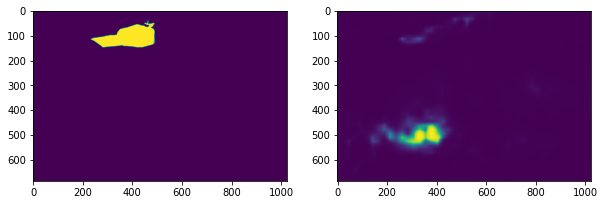

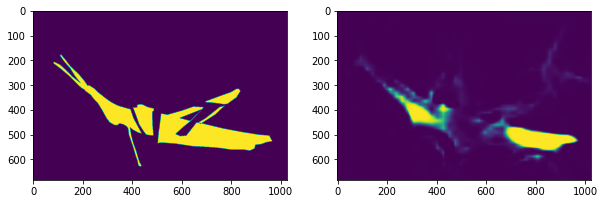

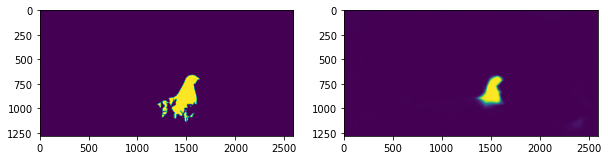

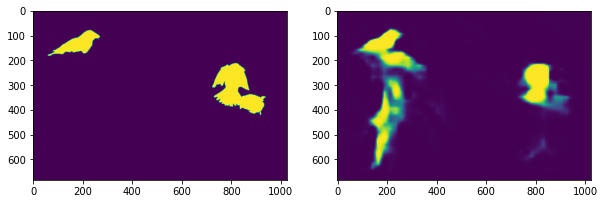

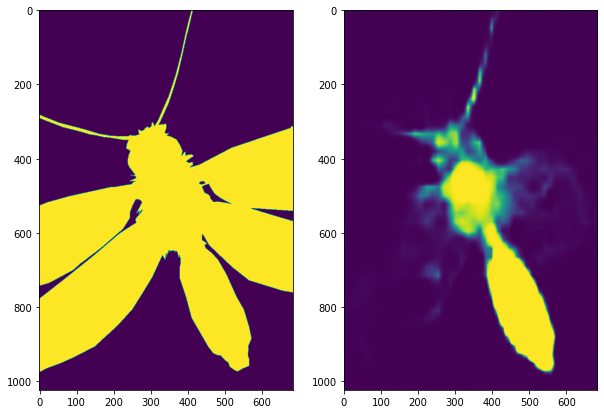

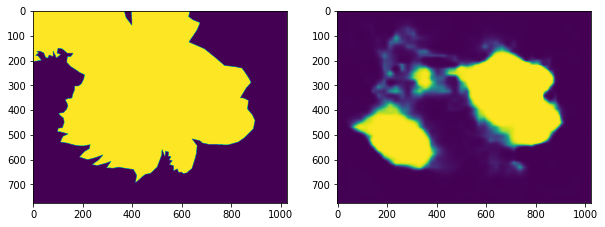

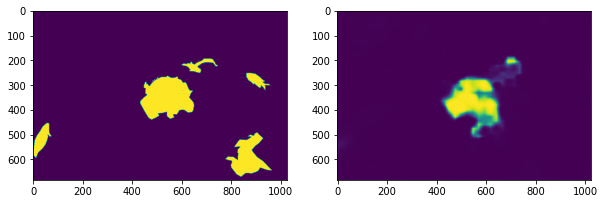

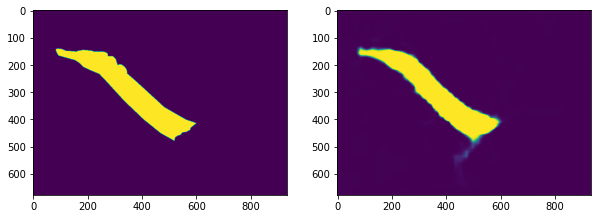

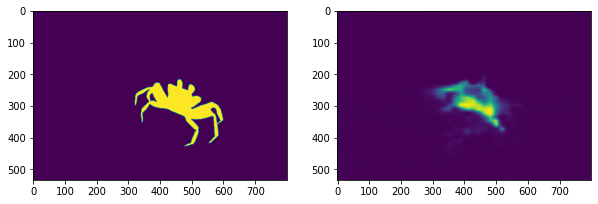

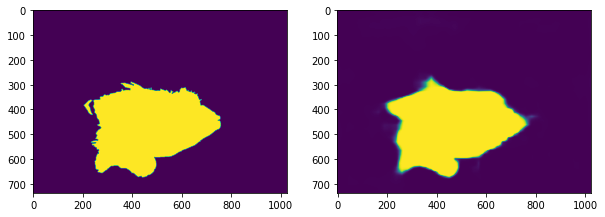

In [ ]:
pred_root_path = '/content/gdrive/MyDrive/DLProject/Results/COD10K/bsize_32/COD10K/'
true_root_path = '/content/TestDataset/COD10K/GT/'

gt_directory = os.listdir(true_root_path)[90:100]
i = 0
gt_list = []
pred_list = []

for k,img_gt in enumerate(gt_directory):
    gt_list.append(img_gt)

for i in range(len(gt_list)):
    plt.figure(figsize=(10,20))
    img_gt= Image.open(true_root_path+"/"+gt_list[i])
    plt.subplot(1,2,1)
    plt.imshow(img_gt)
    
    img_pred = Image.open(pred_root_path+"/"+gt_list[i])
    plt.subplot(1,2,2)
    plt.imshow(img_pred)

MoCA mask data train file

**We have trained MoCA model on our Local computer so we are directly running test function to save re-training time**

In [ ]:
torch.cuda.empty_cache()
#from apex import amp


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--epoch', type=int, default=30,
                        help='epoch number, default=30')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='init learning rate, try `lr=1e-4`')
    parser.add_argument('--batchsize', type=int, default=20,
                        help='training batch size (Note: ~500MB per img in GPU)')
    parser.add_argument('--trainsize', type=int, default=256,
                        help='the size of training image, try small resolutions for speed (like 256)')
    parser.add_argument('--clip', type=float, default=0.5,
                        help='gradient clipping margin')
    parser.add_argument('--decay_rate', type=float, default=0.1,
                        help='decay rate of learning rate per decay step')
    parser.add_argument('--decay_epoch', type=int, default=30,
                        help='every N epochs decay lr')
    parser.add_argument('--gpu', type=int, default=0,
                        help='choose which gpu you use')
    parser.add_argument('--save_epoch', type=int, default=5,
                        help='every N epochs save your trained snapshot')
    parser.add_argument('--save_model', type=str, default='/content/gdrive/My Drive/DLProject/Models/MoCA/')
    parser.add_argument('--trainv_img_dir', type=str, default='/content/MoCA-Mask/MoCA_Video/TrainDataset_per_sq/')

    #opt = parser.parse_args()
    opt, unknown = parser.parse_known_args()

    torch.cuda.set_device(opt.gpu)

    # TIPS: you also can use deeper network for better performance like channel=64
    model_SINet = SINet_ResNet50(channel=32).cuda()
    print('-' * 30, model_SINet, '-' * 30)

    optimizer = torch.optim.Adam(model_SINet.parameters(), opt.lr)
    LogitsBCE = torch.nn.BCEWithLogitsLoss()

    #net, optimizer = amp.initialize(model_SINet, optimizer, opt_level='O1')     # NOTES: Ox not 0x

    train_loader = get_vloader(opt.trainv_img_dir, batchsize=opt.batchsize,
                              trainsize=opt.trainsize, num_workers=0)
    total_step = len(train_loader)

    print('-' * 30, "\n[Training Dataset INFO]\nimg_dir: {}\ngt_dir: {}\nLearning Rate: {}\nBatch Size: {}\n"
                    "Training Save: {}\ntotal_num: {}\n".format(opt.train_img_dir, opt.train_gt_dir, opt.lr,
                                                              opt.batchsize, opt.save_model, total_step), '-' * 30)

    print('-' * 30, "\n[Training Dataset INFO]\nimg_dir: {}\nLearning Rate: {}\nBatch Size: {}\n"
                    "Training Save: {}\ntotal_num: {}\n".format(opt.trainv_img_dir, opt.lr,
                                                              opt.batchsize, opt.save_model, total_step), '-' * 30)

    for epoch_iter in range(1, opt.epoch):
        adjust_lr(optimizer, epoch_iter, opt.decay_rate, opt.decay_epoch)
        trainer(train_loader=train_loader, model=model_SINet,
                optimizer=optimizer, epoch=epoch_iter,
                opt=opt, loss_func=LogitsBCE, total_step=total_step)


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--testsize', type=int, default=352, help='the snapshot input size')
parser.add_argument('--model_path', type=str,
                    default='/content/gdrive/My Drive/DLProject/Models/MoCA/SINet_30.pth')
parser.add_argument('--test_save', type=str,
                    default='/content/gdrive/My Drive/DLProject/Results/MoCA/bsize_10/')
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

model = SINet_ResNet50().cuda()
model.load_state_dict(torch.load(opt.model_path))
model.eval()

for dataset in ['MoCA']:
    save_path = opt.test_save + dataset + '/'
    os.makedirs(save_path, exist_ok=True)
    # NOTES:
    #  if you plan to inference on your customized dataset without grouth-truth,
    #  you just modify the params (i.e., `image_root=your_test_img_path` and `gt_root=your_test_img_path`)
    #  with the same filepath. We recover the original size according to the shape of grouth-truth, and thus,
    #  the grouth-truth map is unnecessary actually.
    test_loader = test_dataset(data_root = '/content/gdrive/MyDrive/DLProject/Dataset/MoCA-Mask/MoCA_Video/TestDataset_per_sq/',
                               testsize=opt.testsize)
    img_count = 1
    for iteration in range(test_loader.size):
        # load data
        image, gt, name = test_loader.load_data()
        gt = np.asarray(gt, np.float32)
        gt /= (gt.max() + 1e-8)
        image = image.cuda()
        # inference
        _, cam = model(image)
        # reshape and squeeze

        cam = F.upsample(cam, size=gt.shape, mode='bilinear', align_corners=True)
        cam = cam.sigmoid().data.cpu().numpy().squeeze()
        # normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        #misc.imsave(save_path+name, cam)
        imageio.imwrite(save_path+name, cam)
        # evaluate
        mae = eval_mae(numpy2tensor(cam), numpy2tensor(gt))
        # coarse score
        print('[Eval-Test] Dataset: {}, Image: {} ({}/{}), MAE: {}'.format(dataset, name, img_count,
                                                                           test_loader.size, mae))
        img_count += 1

print("\n[Congratulations! Testing Done]")

the output was too long so we presenting the last few lines below

```
[Eval-Test] Dataset: MoCA, Image: 00105.png (737/745), MAE: 0.017397549003362656
[Eval-Test] Dataset: MoCA, Image: 00110.png (738/745), MAE: 0.024479800835251808
[Eval-Test] Dataset: MoCA, Image: 00115.png (739/745), MAE: 0.026955096051096916
[Eval-Test] Dataset: MoCA, Image: 00120.png (740/745), MAE: 0.006610711570829153
[Eval-Test] Dataset: MoCA, Image: 00125.png (741/745), MAE: 0.010881214402616024
[Eval-Test] Dataset: MoCA, Image: 00130.png (742/745), MAE: 0.008395131677389145
[Eval-Test] Dataset: MoCA, Image: 00135.png (743/745), MAE: 0.020646657794713974
[Eval-Test] Dataset: MoCA, Image: 00140.png (744/745), MAE: 0.09609111398458481
[Eval-Test] Dataset: MoCA, Image: 00143.png (745/745), MAE: 0.09951233118772507

[Congratulations! Testing Done]
```